### Análisis de Servicio de Deuda y Clasificación de Productores de Caña MX

Este análisis forma parte del problema de optimización de recursos para el **Ecosistema de Producción de Caña en MX**.

Para ello se estudia la información de los productores de caña relacionada a: *Productividad de Caña Proyectada de los terrenos, Obligaciones Financieras Existentes y Obligaciones Financieras Proyectadas*, con el objetivo de estimar **Cocientes Deuda-Ingreso**, **Probabilidades de Impago** y una **Clasificación Financiera** de los Productores.

Las obligaciones *Financieras Proyectadas* son una función del tipo de labor que se requiere en el (los) terreno(s) del productor:
- Siembra (Adecuación, Preparación, Siembra y Manejo).
- Manejo de Plantación.

Para el caso de la **siembra**, se estima que *el primer corte ocurra entre los 12 y 14 meses siguientes* y por lo tanto este período debe considerarse para la proyección de ingresos. En el caso del **manejo**, deberá conocerse el número de corte que se proyecta para los siguientes años (segundo, tercero o cuarto), para poder estimar correctamente el nivel de degradación de productividad del terreno.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Datos de Productividad por Productor MX

El conjunto de datos utilizados para estimar la productividad de los terrenos se basa en el *desempeño histórico, el tercio cosechado y la proyección de degradación de productividad* basada en el número de cortes entre los períodos de renovación.

Dado que un *productor* puede tener uno o varios terrenos, se muestra el **promedio ponderado de la productividad** por productor.

#### EMSA

In [2]:
df_productividad_emsa = pd.read_csv(r'EMSA.csv')
df_productividad_emsa = df_productividad_emsa[['Ingenio','NUMERO CAÑERO','Area total','TCH Base','TCH 2','TCH 3','TCH 4']]
df_productividad_emsa = df_productividad_emsa.melt(id_vars=['Ingenio','NUMERO CAÑERO','Area total'],
        var_name='ZAFRA',
        value_name='TCH')
df_productividad_emsa.loc[df_productividad_emsa['ZAFRA']=='TCH Base','ZAFRA'] = -1 # Zafra pasada, que incluye obligaciones adquiridas previamente por el Productor.
df_productividad_emsa.loc[df_productividad_emsa['ZAFRA']=='TCH 2','ZAFRA'] = 0  # Zafra próxima, en la cual se espera tener siembra (NO PRODUCTIVA) o manejo.
df_productividad_emsa.loc[df_productividad_emsa['ZAFRA']=='TCH 3','ZAFRA'] = 1  # Zafra AÑO 1, en la cual se espera tener el primer corte de caña (siembra) o mayor (manejo).
df_productividad_emsa.loc[df_productividad_emsa['ZAFRA']=='TCH 4','ZAFRA'] = 2  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).
#df_productividad_emsa.loc[df_productividad_emsa['ZAFRA']=='TCH 5','ZAFRA'] = 4  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).
df_productividad_emsa.sort_values(['NUMERO CAÑERO','ZAFRA'],axis=0,inplace=True)
df_productividad_emsa

,Ingenio,NUMERO CAÑERO,Area total,ZAFRA,TCH
0,Mante,5101009,27.00,-1,56.020000
2017,Mante,5101009,27.00,0,43.094741
4034,Mante,5101009,27.00,1,40.501992
6051,Mante,5101009,27.00,2,39.529697
1,Mante,5101012,2.50,-1,56.020000
...,...,...,...,...,...
8066,Mante,5995002,8.25,2,48.850000
2016,Mante,5996001,6.00,-1,68.273937
4033,Mante,5996001,6.00,0,67.666810
6050,Mante,5996001,6.00,1,50.810000


#### IPSA

In [3]:
df_productividad_ipsa = pd.read_csv(r'IPSA.csv')
df_productividad_ipsa = df_productividad_ipsa[['Ingenio','NUMERO CAÑERO','Area total','TCH Base','TCH 2','TCH 3','TCH 4']]
df_productividad_ipsa = df_productividad_ipsa.melt(id_vars=['Ingenio','NUMERO CAÑERO','Area total'],
        var_name='ZAFRA',
        value_name='TCH')
df_productividad_ipsa.loc[df_productividad_ipsa['ZAFRA']=='TCH Base','ZAFRA'] = -1 # Zafra pasada, que incluye obligaciones adquiridas previamente por el Productor.
df_productividad_ipsa.loc[df_productividad_ipsa['ZAFRA']=='TCH 2','ZAFRA'] = 0  # Zafra próxima, en la cual se espera tener siembra (NO PRODUCTIVA) o manejo.
df_productividad_ipsa.loc[df_productividad_ipsa['ZAFRA']=='TCH 3','ZAFRA'] = 1  # Zafra AÑO 1, en la cual se espera tener el primer corte de caña (siembra) o mayor (manejo).
df_productividad_ipsa.loc[df_productividad_ipsa['ZAFRA']=='TCH 4','ZAFRA'] = 2  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).
#df_productividad_ipsa.loc[df_productividad_ipsa['ZAFRA']=='TCH 5','ZAFRA'] = 4  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).
df_productividad_ipsa.sort_values(['NUMERO CAÑERO','ZAFRA'],axis=0,inplace=True)
df_productividad_ipsa

,Ingenio,NUMERO CAÑERO,Area total,ZAFRA,TCH
2430,IPSA,#VALUE!,3.0,-1,62.890000
4861,IPSA,#VALUE!,3.0,0,55.000000
7292,IPSA,#VALUE!,3.0,1,49.970706
9723,IPSA,#VALUE!,3.0,2,51.749960
0,IPSA,1701002,1.5,-1,105.900899
...,...,...,...,...,...
9721,IPSA,3757001,7.0,2,51.749960
2429,IPSA,3757002,6.5,-1,62.890000
4860,IPSA,3757002,6.5,0,55.000000
7291,IPSA,3757002,6.5,1,49.970706


In [4]:
df_productividad = pd.concat([df_productividad_emsa,df_productividad_ipsa])
df_productividad

,Ingenio,NUMERO CAÑERO,Area total,ZAFRA,TCH
0,Mante,5101009,27.0,-1,56.020000
2017,Mante,5101009,27.0,0,43.094741
4034,Mante,5101009,27.0,1,40.501992
6051,Mante,5101009,27.0,2,39.529697
1,Mante,5101012,2.5,-1,56.020000
...,...,...,...,...,...
9721,IPSA,3757001,7.0,2,51.749960
2429,IPSA,3757002,6.5,-1,62.890000
4860,IPSA,3757002,6.5,0,55.000000
7291,IPSA,3757002,6.5,1,49.970706


### Información Financiera de Productores MX

El conjunto de datos financieros incluye información de obligaciones previas y existentes de los productores, así como las cuotas que son fijas.

In [5]:
pd.options.display.max_columns = None
df_financiero = pd.read_csv(r'Productores.csv')
df_financiero = df_financiero[['NUMERO CAÑERO','NOMBRE','SIEMBRA','CORTE','ZAFRA','HECTAREAS','SALDOS DESCTOS. TERCEROS','SALDOS INGENIO','Imss Cuota']]
df_financiero.loc[df_financiero['ZAFRA']=='2023/2024','ZAFRA'] = -1 # Zafra pasada, que incluye obligaciones adquiridas previamente por el Productor.
df_financiero.loc[df_financiero['ZAFRA']=='2024/2025','ZAFRA'] = 0  # Zafra próxima, en la cual se espera tener siembra (NO PRODUCTIVA) o manejo.
df_financiero.loc[df_financiero['ZAFRA']=='2025/2026','ZAFRA'] = 1  # Zafra AÑO 1, en la cual se espera tener el primer corte de caña (siembra) o mayor (manejo).
df_financiero.loc[df_financiero['ZAFRA']=='2026/2027','ZAFRA'] = 2  # Zafra AÑO 2, en la cual se espera tener el segundo corte de caña (siembra) o mayor (manejo).

df_financiero.rename(columns={'SALDOS DESCTOS. TERCEROS': 'FINANCIERAS','Imss Cuota': 'CUOTA IMSS' }, inplace=True)

df_financiero

,NUMERO CAÑERO,NOMBRE,SIEMBRA,CORTE,ZAFRA,HECTAREAS,FINANCIERAS,SALDOS INGENIO,CUOTA IMSS
0,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,0,0,-1,85.5,0.00,734041.45,NaN
1,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,0,0,85.5,0.00,814977.45,NaN
2,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,1,1,85.5,0.00,814977.45,NaN
3,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,2,2,85.5,0.00,814977.45,NaN
4,5101011,"LA PEÑITA DE XICO, S.P.R. DE R.L.",0,0,-1,46.0,165323.56,332178.98,NaN
...,...,...,...,...,...,...,...,...,...
15015,5994001,"JALAPEÑOS Y SERRANOS, SPR RL",0,3,2,8.0,0.00,151200.00,NaN
15016,5994002,"MACAIL, SPR DR RL",0,0,-1,34.0,1296854.35,859756.57,NaN
15017,5994002,"MACAIL, SPR DR RL",1,0,0,34.0,618320.18,649261.29,NaN
15018,5994002,"MACAIL, SPR DR RL",1,1,1,34.0,372463.44,649261.29,NaN


### Unión de Datos Financieros y Productividad Productores de Caña MX

In [6]:
#df = df_financiero.merge(df_productividad, on='NUMERO CAÑERO', how='left')
df = df_financiero.merge(df_productividad, how='left',left_on=['NUMERO CAÑERO', 'ZAFRA'],right_on=['NUMERO CAÑERO', 'ZAFRA'])
df.dropna(subset = ['TCH'], inplace=True)
df

,NUMERO CAÑERO,NOMBRE,SIEMBRA,CORTE,ZAFRA,HECTAREAS,FINANCIERAS,SALDOS INGENIO,CUOTA IMSS,Ingenio,Area total,TCH
0,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,0,0,-1,85.5,0.00,734041.45,NaN,Mante,27.00,56.020000
1,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,0,0,85.5,0.00,814977.45,NaN,Mante,27.00,43.094741
2,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,1,1,85.5,0.00,814977.45,NaN,Mante,27.00,40.501992
3,5101009,RENOVACION AGROPECUARIA S.P.R. DE R.L.,1,2,2,85.5,0.00,814977.45,NaN,Mante,27.00,39.529697
8,5101012,MARINA RAMOS RIOS,0,0,-1,2.5,26856.92,21000.00,NaN,Mante,2.50,56.020000
...,...,...,...,...,...,...,...,...,...,...,...,...
15039,5993001,ALEJANDRA HERNANDEZ VILLEGAS,0,3,2,10.0,6278.75,94500.00,20462.27,Mante,1.25,48.850000
15052,5994002,"MACAIL, SPR DR RL",0,0,-1,34.0,1296854.35,859756.57,NaN,Mante,7.00,68.273937
15053,5994002,"MACAIL, SPR DR RL",1,0,0,34.0,618320.18,649261.29,NaN,Mante,7.00,67.666810
15054,5994002,"MACAIL, SPR DR RL",1,1,1,34.0,372463.44,649261.29,NaN,Mante,7.00,50.810000


In [7]:
df_pivot = df.pivot_table(index=['NUMERO CAÑERO'], 
            columns=['ZAFRA'],values=['HECTAREAS','Area total','SIEMBRA','CORTE','TCH','FINANCIERAS','SALDOS INGENIO','CUOTA IMSS']).fillna(0)

df_pivot

Area total                      CORTE                CUOTA IMSS  \
ZAFRA                 -1      0      1      2    -1    0    1    2         -1   
NUMERO CAÑERO                                                                   
5101009            27.00  27.00  27.00  27.00   0.0  0.0  1.0  2.0       0.00   
5101012             2.50   2.50   2.50   2.50   0.0  1.0  2.0  3.0       0.00   
5101013            23.00  23.00  23.00  23.00   0.0  0.0  1.0  2.0   20462.27   
5101117             3.25   3.25   3.25   3.25   0.0  0.0  1.0  2.0   20462.27   
5101138             9.25   9.25   9.25   9.25   0.0  0.0  1.0  2.0       0.00   
...                  ...    ...    ...    ...   ...  ...  ...  ...        ...   
5989001             1.00   1.00   1.00   1.00   0.0  2.0  3.0  4.0   20462.27   
5991001             5.50   5.50   5.50   5.50   0.0  0.0  1.0  2.0   20462.27   
5992001             7.00   7.00   7.00   7.00   0.0  0.0  1.0  2.0   20462.27   
5993001             1.25   1.25   1.25   1.25   0.0  1.0  2.0  3.0   20462.27   
5994002             7.00   7.00   7.00   7.00   0.0  0.0  1.0  2.0       0.00   

                                            FINANCIERAS                        \
ZAFRA                 0         1         2          -1          0          1   
NUMERO CAÑERO                                                                   
5101009            0.00      0.00      0.00        0.00       0.00       0.00   
5101012            0.00      0.00      0.00    26856.92   14194.14       0.00   
5101013        20462.27  20462.27  20462.27   195580.31       0.00       0.00   
5101117        20462.27  20462.27  20462.27    13128.76    3811.26    3811.26   
5101138            0.00      0.00      0.00        0.00       0.00       0.00   
...                 ...       ...       ...         ...        ...        ...   
5989001        20462.27  20462.27  20462.27   308714.40  146591.47   87931.58   
5991001        20462.27  20462.27  20462.27   143639.64   67958.71   40215.32   
5992001        20462.27  20462.27  20462.27    90101.17   35748.17   35748.17   
5993001        20462.27  20462.27  20462.27   212241.53   86174.76   77528.78   
5994002            0.00      0.00      0.00  1296854.35  618320.18  372463.44   

                       HECTAREAS                      SALDOS INGENIO  \
ZAFRA                2        -1      0      1      2             -1   
NUMERO CAÑERO                                                          
5101009           0.00     85.50  85.50  85.50  85.50      734041.45   
5101012           0.00      2.50   2.50   2.50   2.50       21000.00   
5101013           0.00     23.00  23.00  23.00  23.00       96600.00   
5101117           0.00      3.25   3.25   3.25   3.25       31196.02   
5101138           0.00      9.25   9.25   9.25   9.25       95856.44   
...                ...       ...    ...    ...    ...            ...   
5989001           0.00     12.00  12.00  12.00  12.00      237914.74   
5991001           0.00      6.00   6.00   6.00   6.00       69300.00   
5992001           0.00      7.00   7.00   7.00   7.00       58800.00   
5993001        6278.75     10.00  10.00  10.00  10.00      188880.64   
5994002           0.00     34.00  34.00  34.00  34.00      859756.57   

                                               SIEMBRA                 \
ZAFRA                  0          1          2      -1    0    1    2   
NUMERO CAÑERO                                                           
5101009        814977.45  814977.45  814977.45     0.0  1.0  1.0  1.0   
5101012         21000.00   21000.00   21000.00     0.0  0.0  0.0  0.0   
5101013         96600.00   96600.00   96600.00     0.0  1.0  1.0  1.0   
5101117         20475.00   20475.00   20475.00     0.0  1.0  1.0  1.0   
5101138         92843.85   77700.00   77700.00     0.0  1.0  1.0  1.0   
...                  ...        ...        ...     ...  ...  ...  ...   
5989001        172469.28  172469.28  126000.00     0.0  0.0  0.0  0.0   
59910

### Parámetros Financieros

Estos parámetros incluyen información de beneficios, precios, costos, tasas de amortización (para cada tipo de labor) y cuotas que están en función de la producción de caña proyectada.

In [8]:
# Beneficios
BenMarCañaEMSA = 30 # Beneficio Marginal por Tonelada de Caña EMSA (USD/t Caña)
BenMarCañaIPSA = 40 # Beneficio Marginal por Tonelada de Caña IPSA (USD/t Caña)

# Precio Caña (Ingreso de Productor)
PrecioCañaEMSA = 65 # Precio por Tonelada de Caña EMSA (USD/t Caña)
PrecioCañaIPSA = 65 # Precio por Tonelada de Caña IPSA (USD/t Caña)

# Costo
CostoRenovacion = 1000 # Costo por Hectárea de Renovacion (USD/ha)
CostoManejo = 800 # Costo por Hectárea de Manejo (USD/ha)

# Préstamo
Tasa = 0.2 # Tasa de Interés (%)
AmortizacionAPS = [0,0.5,0.25,0.25,0] # Amortización APS (%)
AmortizacionSIEMBRA_MANEJO = [0,1,1,1,1] # Amortización Manejo (%)
AmortizacionMANEJO = [1,1,1,1,1] # Amortización Manejo (%)

# Cuotas
CuotaLocal = 0.8333 # Cuota Local (USD/t Caña)
MasaComun = 6.9444 # Masa Común (USD/t Caña)
CuotaNacional = 0.5/100 # Cuota Nacional (% del Ingreso)
CONADESUCA = 0.015 # Cuota CONADESUCA (USD/t Caña)
IMSS = 1.2044 # Cuota IMSS (USD/t Caña)
IMSS_Fijo = 1136.8333 # Cuota Fija IMSS (USD)
CAT = 11.6667 # CAT (USD/t Caña)


### Cálculo de Ingresos del Productor

El cálculo del *Ingreso* para un productor se basa en la siguiente ecuación que estima el monto a ganar en función de la cantidad de caña proyectada:
$$ Beneficio_{Productor,Zafra} = TCH_{Productor,Zafra}*Area_{Productor}*Precio_{Caña} $$

In [9]:
for i in range(5):
    df_pivot[('CAÑA TOTAL',i)] = df_pivot[('TCH',0)] * df_pivot[('Area total',0)] # Incluir estimados de TCH!
    
for i in range(5):
    df_pivot[('BENEFICIO',i)] = PrecioCañaEMSA * df_pivot[('CAÑA TOTAL',i)] # Beneficio Total por Caña

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                          CAÑA TOTAL  \
ZAFRA                     2             3             4            0   
NUMERO CAÑERO                                                          
5101009        75631.269876  75631.269876  75631.269876  1163.557998   
5101012         7002.895359   7002.895359   7002.895359   107.736852   
5101013        64426.637302  64426.637302  64426.637302   991.179035   
5101117         9103.763967   9103.763967   9103.763967   140.057907   
5101138        25910.712828  25910.712828  25910.712828   398.626351   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1163.557998  1163.557998  1163.557998  1163.557998   0.0  0.0   
5101012         107.736852   107.736852   107.736852   107.736852   0.0  1.0   
5101013         991.179035   991.179035   991.179035   991.179035   0.0  0.0   
5101117         140.057907   140.057907   140.057907   140.057907   0.0  0.0   
5101138         398.626351   398.626351   398.626351   398.626351   0.0  0.0   

                        CUOTA IMSS                               FINANCIERAS  \
ZAFRA            1    2         -1         0         1         2          -1   
NUMERO CAÑERO                                                                  
5101009        1.0  2.0       0.00      0.00      0.00      0.00        0.00   
5101012        2.0  3.0       0.00      0.00      0.00      0.00    26856.92   
5101013        1.0  2.0   20462.27  20462.27  20462.27  20462.27   195580.31   
5101117        1.0  2.0   20462.27  20462.27  20462.27  20462.27    13128.76   
5101138        1.0  2.0       0.00      0.00      0.00      0.00        0.00   

                                      HECTAREAS                       \
ZAFRA                 0        1    2        -1      0      1      2   
NUMERO CAÑERO                                                          
5101009            0.00     0.00  0.0     85.50  85.50  85.50  85.50   
5101012        14194.14     0.00  0.0      2.50   2.50   2.50   2.50   
5101013            0.00     0.00  0.0     23.00  23.00  23.00  23.00   
5101117         3811.26  3811.26  0.0      3.25   3.25   3.25   3.25   
5101138            0.00     0.00  0.0      9.25   9.25   9.25   9.25   

              SALDOS INGENIO                                  SIEMBRA       \
ZAFRA                     -1          0          1          2      -1    0   
NUMERO CAÑERO                                                                
5101009            734041.45  814977.45  814977.45  814977.45     0.0  1.0   
5101012             21000.00   21000.00   21000.00   21000.00     0.0  0.0   
5101013             96600.00   96600.00   96600.00   96600.00     0.0  1.0   
5101117             31196.02   20475.00   20475.00   20475.00     0.0  1.0   
5101138             95856.44   92843.85   77700.00   77700.00     0.0  1.0   

                           TCH                                   
ZAFRA            1    2     -1          0          1          2  
NUMERO CAÑERO                                                    
5101009        1.0  1.0  56.02  43.094741  40.501992  39.529697  
5101012        0.0  0.0  56.02  43.094741  40.501992  39.529697  
510101

### Costo APS

El costo de Adecuación, Preparación y Siembra es el costo en el que se incurre al realizar la actividad de *Siembra*. Al realizar la actividad de *Siembra* los ingresos de la caña sembrada se obtendrán en un período entre 12 y 14 meses posterior a la siembra. Los costos de APS son una función del área del terreno y se incurre en el mismo de **manera única en el Año 0**, para amortizarlo en los siguientes 3 años, típicamente con un esquema **Año 0: 0%, Año 1: 50%, Año 2: 25% y Año 3: 25%**.

- $ SaldoInicialAPS_{Productor,Zafra=0} = CostoRenovacion * Area_{Productor} $
- $ SaldoInicialAPS_{Productor,Zafra>0} = SaldoFinalAPS_{Productor,Zafra-1} $
- $ TasaAmortizacionAPS_{Productor,Zafra=0} = 0, TasaAmortizacionAPS_{Productor,Zafra=1} = 0.5, TasaAmortizacionAPS_{Productor,Zafra=2} = 0.25, TasaAmortizacionAPS_{Productor,Zafra=3} = 0.25 $
- $ Amortizacion APS_{Productor,Zafra} = TasaAmortizacionAPS_{Productor,Zafra} * SaldoInicialAPS_{Productor,Zafra=0}$
- $ Intereses_{Productor,Zafra=0} = 0, Intereses_{Productor,Zafra>0} = TasaInteres * SaldoFinalAPS_{Productor,Zafra-1} $
- $ SaldoFinalAPS_{Productor,Zafra} = SaldoInicialAPS_{Productor,Zafra} - AmortizacionAPS_{Productor,Zafra} $
- $ ServicioDeudaIncrementalAPS_{Productor,Zafra} = AmortizacionAPS_{Productor,Zafra} + Intereses_{Productor,Zafra} $

In [10]:
# AÑO 0
df_pivot[('SALDO INICIAL APS',0)] = CostoRenovacion * df_pivot[('HECTAREAS',0)]
df_pivot[('AMORTIZACION APS',0)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[0]
df_pivot[('INTERES APS',0)] = 0
df_pivot[('SALDO FINAL APS',0)] = df_pivot[('SALDO INICIAL APS',0)] - df_pivot[('AMORTIZACION APS',0)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',0)] = df_pivot[('AMORTIZACION APS',0)] + df_pivot[('INTERES APS',0)]

# AÑO 1
df_pivot[('SALDO INICIAL APS',1)] = df_pivot[('SALDO FINAL APS',0)]
df_pivot[('AMORTIZACION APS',1)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[1]
df_pivot[('INTERES APS',1)] = df_pivot[('SALDO FINAL APS',0)] * Tasa
df_pivot[('SALDO FINAL APS',1)] = df_pivot[('SALDO INICIAL APS',1)] - df_pivot[('AMORTIZACION APS',1)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',1)] = df_pivot[('AMORTIZACION APS',1)] + df_pivot[('INTERES APS',1)]

# AÑO 2
df_pivot[('SALDO INICIAL APS',2)] = df_pivot[('SALDO FINAL APS',1)]
df_pivot[('AMORTIZACION APS',2)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[2]
df_pivot[('INTERES APS',2)] = df_pivot[('SALDO FINAL APS',1)] * Tasa
df_pivot[('SALDO FINAL APS',2)] = df_pivot[('SALDO INICIAL APS',2)] - df_pivot[('AMORTIZACION APS',2)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',2)] = df_pivot[('AMORTIZACION APS',2)] + df_pivot[('INTERES APS',2)]

# AÑO 3
df_pivot[('SALDO INICIAL APS',3)] = df_pivot[('SALDO FINAL APS',2)]
df_pivot[('AMORTIZACION APS',3)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[3]
df_pivot[('INTERES APS',3)] = df_pivot[('SALDO FINAL APS',2)] * Tasa
df_pivot[('SALDO FINAL APS',3)] = df_pivot[('SALDO INICIAL APS',3)] - df_pivot[('AMORTIZACION APS',3)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',3)] = df_pivot[('AMORTIZACION APS',3)] + df_pivot[('INTERES APS',3)]

# AÑO 4
df_pivot[('SALDO INICIAL APS',4)] = df_pivot[('SALDO FINAL APS',3)]
df_pivot[('AMORTIZACION APS',4)] = df_pivot[('SALDO INICIAL APS',0)] * AmortizacionAPS[4]
df_pivot[('INTERES APS',4)] = df_pivot[('SALDO FINAL APS',3)] * Tasa
df_pivot[('SALDO FINAL APS',4)] = df_pivot[('SALDO INICIAL APS',4)] - df_pivot[('AMORTIZACION APS',4)]
df_pivot[('SALDO DEUDA INCREMENTAL APS',4)] = df_pivot[('AMORTIZACION APS',4)] + df_pivot[('INTERES APS',4)]

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                 Area total  \
ZAFRA                        0        1        2        3    4         -1   
NUMERO CAÑERO                                                               
5101009                    0.0  42750.0  21375.0  21375.0  0.0      27.00   
5101012                    0.0   1250.0    625.0    625.0  0.0       2.50   
5101013                    0.0  11500.0   5750.0   5750.0  0.0      23.00   
5101117                    0.0   1625.0    812.5    812.5  0.0       3.25   
5101138                    0.0   4625.0   2312.5   2312.5  0.0       9.25   

                                       BENEFICIO                              \
ZAFRA              0      1      2             0             1             2   
NUMERO CAÑERO                                                                  
5101009        27.00  27.00  27.00  75631.269876  75631.269876  75631.269876   
5101012         2.50   2.50   2.50   7002.895359   7002.895359   7002.895359   
5101013        23.00  23.00  23.00  64426.637302  64426.637302  64426.637302   
5101117         3.25   3.25   3.25   9103.763967   9103.763967   9103.763967   
5101138         9.25   9.25   9.25  25910.712828  25910.712828  25910.712828   

                                            CAÑA TOTAL               \
ZAFRA                     3             4            0            1   
NUMERO CAÑERO                                                         
5101009        75631.269876  75631.269876  1163.557998  1163.557998   
5101012         7002.895359   7002.895359   107.736852   107.736852   
5101013        64426.637302  64426.637302   991.179035   991.179035   
5101117         9103.763967   9103.763967   140.057907   140.057907   
5101138        25910.712828  25910.712828   398.626351   398.626351   

                                                     CORTE                 \
ZAFRA                    2            3            4    -1    0    1    2   
NUMERO CAÑERO                                                               
5101009        1163.557998  1163.557998  1163.557998   0.0  0.0  1.0  2.0   
5101012         107.736852   107.736852   107.736852   0.0  1.0  2.0  3.0   
5101013         991.179035   991.179035   991.179035   0.0  0.0  1.0  2.0   
5101117         140.057907   140.057907   140.057907   0.0  0.0  1.0  2.0   
5101138         398.626351   398.626351   398.626351   0.0  0.0  1.0  2.0   

              CUOTA IMSS                               FINANCIERAS            \
ZAFRA                 -1         0         1         2          -1         0   
NUMERO CAÑERO                                                                  
5101009             0.00      0.00      0.00      0.00        0.00      0.00   
5101012             0.00      0.00      0.00      0.00    26856.92  14194.14   
5101013         20462.27  20462.27  20462.27  20462.27   195580.31      0.00   
5101117         20462.27  20462.27  20462.27  20462.27    13128.76   3811.26   
5101138             0.00      0.00      0.00      0.00        0.00      0.00   

                            HECTAREAS                      INTERES APS  \
ZAFRA                1    2        -1      0      1      2           0   
NUMERO CAÑERO                                                            
5101009           0.00  0.0     85.50  85.50  85.50  85.50           0   
5101012           0.00  0.0      2.50   2.50   2.50   2.50           0   
5101013           0.00  0.0     23.00  23.00  23.00  23.00           0   
5101117        3811.26  0.0      3.25   3.25   3.25   3.25           0   
5101138           0.00  0.0      9.25   9.25   9.25   9.25           0   

                                            SALDO DEUDA INCREMENTAL APS  \
ZAFRA                1       2       3    4                           0   
NUMERO CAÑERO                                                             
5101009        17100.0  8550.0  4275.0  0.0                         0.0   
5101012          500.0   250.0   125

### Costo Manejo

El costo de Manejo es el costo en el que se incurre al realizar la actividad de *Siembra* y/o *Manejo*. En otras palabras, la actividad de *Siembra* siempre implica la actividad de *Manejo* y por lo tanto la actividad de Siembra siempre incurre en costos de Manejo, sin embargo también es posible solo tener *Manejo* sin tener Siembra. Los costos de Manejo son una función del área del terreno y se incurre en el mismo en **todos los años**, para amortizarlo siempre en el mismo año. Es decir un esquema de amortización de *Manejo con Siembra* de **Año 0: 0%, Año 1: 100%, Año 2: 100% y Año 3: 100%** y *Manejo sin Siembra* de **Año 0: 100%, Año 1: 100%, Año 2: 100% y Año 3: 100%**

- $ SaldoInicialManejo_{Productor,Zafra=0} = CostoManejo * Area_{Productor} $
- $ SaldoInicialManejo_{Productor,Zafra>0} = SaldoFinalManejo_{Productor,Zafra-1} $
- $ TasaAmortizacionSiembraManejo_{Productor,Zafra=0} = 0, TasaAmortizacionSiembraManejo_{Productor,Zafra=1} = 1.0, TasaAmortizacionSiembraManejo_{Productor,Zafra=2} = 1.0, TasaAmortizacionSiembraManejo_{Productor,Zafra=3} = 1.0 $
- $ AmortizacionSiembraManejo_{Productor,Zafra} = TasaAmortizacionSiembraManejo_{Productor,Zafra} * SaldoInicialManejo_{Productor,Zafra=0}$
- $ TasaAmortizacionManejo_{Productor,Zafra=0} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=1} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=2} = 1.0, TasaAmortizacionManejo_{Productor,Zafra=3} = 1.0 $
- $ AmortizacionManejo_{Productor,Zafra} = TasaAmortizacionManejo_{Productor,Zafra} * SaldoInicialManejo_{Productor,Zafra=0}$
- $ Intereses_{Productor,Zafra=0} = 0, Intereses_{Productor,Zafra>0} = TasaInteres * SaldoFinalManejo_{Productor,Zafra-1} $
- $ SaldoFinalManejo_{Productor,Zafra} = SaldoInicialManejo_{Productor,Zafra} - AmortizacionManejo_{Productor,Zafra} $
- $ ServicioDeudaIncrementalManejo_{Productor,Zafra} = AmortizacionManejo_{Productor,Zafra} + Intereses_{Productor,Zafra} $

In [11]:
# AÑO 0
df_pivot[('SALDO INICIAL MANEJO',0)] = CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[0] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[0] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',0)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',0)] = 0
df_pivot[('SALDO FINAL MANEJO',0)] = df_pivot[('SALDO INICIAL MANEJO',0)] - df_pivot[('AMORTIZACION MANEJO',0)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',0)] = df_pivot[('AMORTIZACION MANEJO',0)] + df_pivot[('INTERES MANEJO',0)]

# AÑO 1
df_pivot[('SALDO INICIAL MANEJO',1)] = df_pivot[('SALDO FINAL MANEJO',0)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[1] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[1] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',1)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',1)] = df_pivot[('SALDO FINAL MANEJO',0)] * Tasa
df_pivot[('SALDO FINAL MANEJO',1)] = df_pivot[('SALDO INICIAL MANEJO',1)] - df_pivot[('AMORTIZACION MANEJO',1)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',1)] = df_pivot[('AMORTIZACION MANEJO',1)] + df_pivot[('INTERES MANEJO',1)]

# AÑO 2
df_pivot[('SALDO INICIAL MANEJO',2)] = df_pivot[('SALDO FINAL MANEJO',1)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[2] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[2] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',2)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',2)] = df_pivot[('SALDO FINAL MANEJO',1)] * Tasa
df_pivot[('SALDO FINAL MANEJO',2)] = df_pivot[('SALDO INICIAL MANEJO',2)] - df_pivot[('AMORTIZACION MANEJO',2)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',2)] = df_pivot[('AMORTIZACION MANEJO',2)] + df_pivot[('INTERES MANEJO',2)]

# AÑO 3
df_pivot[('SALDO INICIAL MANEJO',3)] = df_pivot[('SALDO FINAL MANEJO',2)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[3] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[3] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',3)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',3)] = df_pivot[('SALDO FINAL MANEJO',2)] * Tasa
df_pivot[('SALDO FINAL MANEJO',3)] = df_pivot[('SALDO INICIAL MANEJO',3)] - df_pivot[('AMORTIZACION MANEJO',3)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',3)] = df_pivot[('AMORTIZACION MANEJO',3)] + df_pivot[('INTERES MANEJO',3)]

# AÑO 4
df_pivot[('SALDO INICIAL MANEJO',4)] = df_pivot[('SALDO FINAL MANEJO',3)] + CostoManejo * df_pivot[('HECTAREAS',0)]
df1_amortizacion_SM = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==1] * AmortizacionSIEMBRA_MANEJO[4] # Amortizacion Siembra + Manejo
df1_amortizacion_M = df_pivot[('SALDO INICIAL MANEJO',0)][df_pivot[('SIEMBRA',0)]==0] * AmortizacionMANEJO[4] # Amortizacion Manejo
df1 = pd.DataFrame(pd.concat([df1_amortizacion_SM,df1_amortizacion_M],axis=0)).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION MANEJO']]
df_pivot[('AMORTIZACION MANEJO',4)] = df1['AMORTIZACION MANEJO']
df_pivot[('INTERES MANEJO',4)] = df_pivot[('SALDO FINAL MANEJO',3)] * Tasa
df_pivot[('SALDO FINAL MANEJO',4)] = df_pivot[('SALDO INICIAL MANEJO',4)] - df_pivot[('AMORTIZACION MANEJO',4)]
df_pivot[('SALDO DEUDA INCREMENTAL MANEJO',4)] = df_pivot[('AMORTIZACION MANEJO',4)] + df_pivot[('INTERES MANEJO',4)]

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                          CAÑA TOTAL  \
ZAFRA                     2             3             4            0   
NUMERO CAÑERO                                                          
5101009        75631.269876  75631.269876  75631.269876  1163.557998   
5101012         7002.895359   7002.895359   7002.895359   107.736852   
5101013        64426.637302  64426.637302  64426.637302   991.179035   
5101117         9103.763967   9103.763967   9103.763967   140.057907   
5101138        25910.712828  25910.712828  25910.712828   398.626351   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1163.557998  1163.557998  1163.557998  1163.557998   0.0  0.0   
5101012         107.736852   107.736852   107.736852   107.736852   0.0  1.0   
5101013         991.179035   991.179035   991.179035   991.179035   0.0  0.0   
5101117         140.057907   140.057907   140.057907   140.057907   0.0  0.0   
5101138         398.626351   398.626351   398.626351   398.626351   0.0  0.0   

                        CUOTA IMSS                               FINANCIERAS  \
ZAFRA            1    2         -1         0         1         2          -1   
NUMERO CAÑERO                                                                  
5101009        1.0  2.0       0.00      0.00      0.00      0.00        0.00   
5101012        2.0  3.0       0.00      0.00      0.00      0.00    26856.92   
5101013        1.0  2.0   20462.27  20462.27  20462.27  20462.27   195580.31   
5101117        1.0  2.0   20462.27  20462.27  20462.27  20462.27    13128.76   
5101138        1.0  2.0       0.00      0.00      0.00      0.00        0.00   

                                      HECTAREAS                       \
ZAFRA                 0        1    2        -1      0      1      2   
NUMERO CAÑERO                                                          
5101009            0.00     0.00  0.0     85.50  85.50  85.50  85.50   
5101012        14194.14     0.00  0.0      2.50   2.50   2.50   2.50   
5101013            0.00     0.00  0.0     23.00  23.00  23.00  2

### Saldos de Deuda Total

Los saldos de deuda permiten calcular las obligaciones proyectadas del productor. Esto permite estimar su cociente *deuda-ingreso* en el futuro. 

Para hacer una proyección adecuada es necesario conocer si en el año 0 se hará una labor de **siembra** o solamente de **manejo**. En el caso que se proyecte realizar una siembra, los costos serán los relacionados a **APS + MANEJO**. Por otro lado, si solamente se proyecta realizar manejo los costos relacionados serán únicamente de **MANEJO**.

#### Saldo de Deuda Incremental Total

El saldo de deuda incremental total es función de la actividad a realizar, de la siguiente manera:

SIEMBRA:
- $ SaldoDeudaIncrementalTotal_{Productor,Zafra} = SaldoDeudaIncrementalAPS_{Productor,Zafra} + SaldoDeudaIncrementalManejo_{Productor,Zafra} $

MANEJO:
- $ SaldoDeudaIncrementalTotal_{Productor,Zafra} = SaldoDeudaIncrementalManejo_{Productor,Zafra} $

#### Saldo de Deuda Total
- $ SaldoDeudaTotal_{Productor,Zafra} = SaldoFinalAPS_{Productor,Zafra} + SaldoFinalManejo_{Productor,Zafra} $

In [12]:
# Saldos de Deuda Incremental Total
df1_siembra = df_pivot[('SALDO DEUDA INCREMENTAL APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('SALDO DEUDA INCREMENTAL MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df1_manejo = df_pivot[('SALDO DEUDA INCREMENTAL MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df1 = pd.concat([df1_siembra,df1_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['SALDO DEUDA INCREMENTAL TOTAL'] * len(df1.columns), df1.columns]

# Saldos de Deuda Total
df2_siembra = df_pivot[('SALDO FINAL APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('SALDO FINAL MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df2_manejo = df_pivot[('SALDO FINAL MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df2 = pd.concat([df2_siembra,df2_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df2.columns = [['SALDO DEUDA TOTAL'] * len(df2.columns), df2.columns]

df_pivot = df_pivot.join([df1,df2])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                          CAÑA TOTAL  \
ZAFRA                     2             3             4            0   
NUMERO CAÑERO                                                          
5101009        75631.269876  75631.269876  75631.269876  1163.557998   
5101012         7002.895359   7002.895359   7002.895359   107.736852   
5101013        64426.637302  64426.637302  64426.637302   991.179035   
5101117         9103.763967   9103.763967   9103.763967   140.057907   
5101138        25910.712828  25910.712828  25910.712828   398.626351   

                                                                  CORTE       \
ZAFRA                    1            2            3            4    -1    0   
NUMERO CAÑERO                                                                  
5101009        1163.557998  1163.557998  1163.557998  1163.557998   0.0  0.0   
5101012         107.736852   107.736852   107.736852   107.736852   0.0  1.0   
5101013         991.179035   991.179035   991.179035   991.179035   0.0  0.0   
5101117         140.057907   140.057907   140.057907   140.057907   0.0  0.0   
5101138         398.626351   398.626351   398.626351   398.626351   0.0  0.0   

                        CUOTA IMSS                               FINANCIERAS  \
ZAFRA            1    2         -1         0         1         2          -1   
NUMERO CAÑERO                                                                  
5101009        1.0  2.0       0.00      0.00      0.00      0.00        0.00   
5101012        2.0  3.0       0.00      0.00      0.00      0.00    26856.92   
5101013        1.0  2.0   20462.27  20462.27  20462.27  20462.27   195580.31   
5101117        1.0  2.0   20462.27  20462.27  20462.27  20462.27    13128.76   
5101138        1.0  2.0       0.00      0.00      0.00      0.00        0.00   

                                      HECTAREAS                       \
ZAFRA                 0        1    2        -1      0      1      2   
NUMERO CAÑERO                                                          
5101009            0.00     0.00  0.0     85.50  85.50  85.50  85.50   
5101012        14194.14     0.00  0.0      2.50   2.50   2.50   2.50   
5101013            0.00     0.00  0.0     23.00  23.00  23.00  2

### Gastos Legal

In [13]:
# Cuota Local
df1 = df_pivot['CAÑA TOTAL']*CuotaLocal
df7 = df1.copy()
df1.columns = [['CUOTA LOCAL'] * len(df1.columns), df1.columns]

# Masa Común
df2 = df_pivot['CAÑA TOTAL']*MasaComun
df7 += df2.copy()
df2.columns = [['MASA COMUN'] * len(df2.columns), df2.columns]

# Cuota Nacional
df3 = df_pivot['BENEFICIO']*CuotaNacional
df7 += df3.copy()
df3.columns = [['CUOTA NACIONAL'] * len(df3.columns), df3.columns]

# Cuota CONADESUCA
df4 = df_pivot['CAÑA TOTAL']*CONADESUCA
df7 += df4.copy()
df4.columns = [['CUOTA CONADESUCA'] * len(df4.columns), df4.columns]

# IMSS
df5 = df_pivot['CAÑA TOTAL']*IMSS
df7 += df5.copy()
df5.columns = [['IMSS'] * len(df5.columns), df5.columns]

# CAT
df6 = df_pivot['CAÑA TOTAL']*CAT
df7 += df6.copy()
df6.columns = [['CAT'] * len(df6.columns), df6.columns]

# LEGAL TOTAL
df_pivot[('CUOTA IMSS'),3] = df_pivot[('CUOTA IMSS'),2]
df_pivot[('CUOTA IMSS'),4] = df_pivot[('CUOTA IMSS'),2]
df_pivot.drop(('CUOTA IMSS',-1),axis=1,inplace=True)
df7 += df_pivot[('CUOTA IMSS')]
df7.columns = [['LEGAL'] * len(df7.columns), df7.columns]

df_pivot = df_pivot.join([df1,df2,df3,df4,df5,df6,df7])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398.626351   398.626351   

                           CORTE                CUOTA CONADESUCA             \
ZAFRA                    4    -1    0    1    2                0          1   
NUMERO CAÑERO                                                                 
5101009        1163.557998   0.0  0.0  1.0  2.0        17.453370  17.453370   
5101012         107.736852   0.0  1.0  2.0  3.0         1.616053   1.616053   
5101013         991.179035   0.0  0.0  1.0  2.0        14.867686  14.867686   
5101117         140.057907   0.0  0.0  1.0  2.0         2.100869   2.100869   
5101138

### Cálculo del Egreso Total

Para el egreso total se consideran gastos en la categoría de **Financieras**, **Ingenio**, **CAT**, **Legal** y el **Servicio de Deuda Total**.

In [14]:
# Financieras (es necesario tener proyecciones para los años 3 y 4)
df_pivot[('FINANCIERAS'),3] = df_pivot[('FINANCIERAS'),2]*0.8
df_pivot[('FINANCIERAS'),4] = df_pivot[('FINANCIERAS'),2]*0.4
df_pivot.drop(('FINANCIERAS',-1),axis=1,inplace=True)

# Ingenio (es necesario tener proyecciones para los años 3 y 4)
df_pivot[('SALDOS INGENIO'),3] = df_pivot[('SALDOS INGENIO'),2]*0.8
df_pivot[('SALDOS INGENIO'),4] = df_pivot[('SALDOS INGENIO'),2]*0.4
df_pivot.drop(('SALDOS INGENIO',-1),axis=1,inplace=True)

df1 = df_pivot['SALDO DEUDA TOTAL'] + df_pivot['LEGAL'] + df_pivot['CAT'] + df_pivot['FINANCIERAS'] + df_pivot['SALDOS INGENIO']
df1.columns = [['EGRESO'] * len(df1.columns), df1.columns]

df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398.626351   398.626351   

                           CORTE                CUOTA CONADESUCA             \
ZAFRA                    4    -1    0    1    2                0          1   
NUMERO CAÑERO                                                                 
5101009        1163.557998   0.0  0.0  1.0  2.0        17.453370  17.453370   
5101012         107.736852   0.0  1.0  2.0  3.0         1.616053   1.616053   
5101013         991.179035   0.0  0.0  1.0  2.0        14.867686  14.867686   
5101117         140.057907   0.0  0.0  1.0  2.0         2.100869   2.100869   
5101138

### Ratios Deuda - Ingreso

In [15]:
# Ratio Deuda-Ingreso
#df1 = df_pivot['SALDO DEUDA TOTAL']/df_pivot['BENEFICIO']
df1 = df_pivot['EGRESO']/df_pivot['BENEFICIO']
df1.columns = [['DEBT-INCOME RATIO'] * len(df1.columns), df1.columns]
df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398.626351   398.626351   

                           CORTE                CUOTA CONADESUCA             \
ZAFRA                    4    -1    0    1    2                0          1   
NUMERO CAÑERO                                                                 
5101009        1163.557998   0.0  0.0  1.0  2.0        17.453370  17.453370   
5101012         107.736852   0.0  1.0  2.0  3.0         1.616053   1.616053   
5101013         991.179035   0.0  0.0  1.0  2.0        14.867686  14.867686   
5101117         140.057907   0.0  0.0  1.0  2.0         2.100869   2.100869   
5101138

### Progresión de la Distribución del Cociente Deuda-Ingreso

Se presenta la distribuición del cociente Deuda-Ingreso de los productores. Por medio de este análisis gráfico puede observarse el comportamiento del cociente al avanzar los años, de acuerdo con los Ingresos y Obligaciones proyectadas para cada productor.

*Es deseable que la distribución reduzca su varianza y su media al transcurrir los años*.

DEBT-INCOME RATIO                                                    
ZAFRA                 0            1            2            3            4
count       1469.000000  1469.000000  1469.000000  1469.000000  1469.000000
mean           7.493507     6.633215     5.885079     4.947584     3.201602
std           15.482418    12.583874     9.859261     7.938591     4.368050
min            0.652893     0.652893     0.652893     0.622793     0.562593
25%            3.031726     2.840711     2.751462     2.301648     1.551958
50%            4.251353     4.017356     3.875997     3.201276     2.226679
75%            6.361811     5.801077     5.374678     4.662262     3.228253
max          317.838430   231.419300   147.816460   118.353646    63.345716

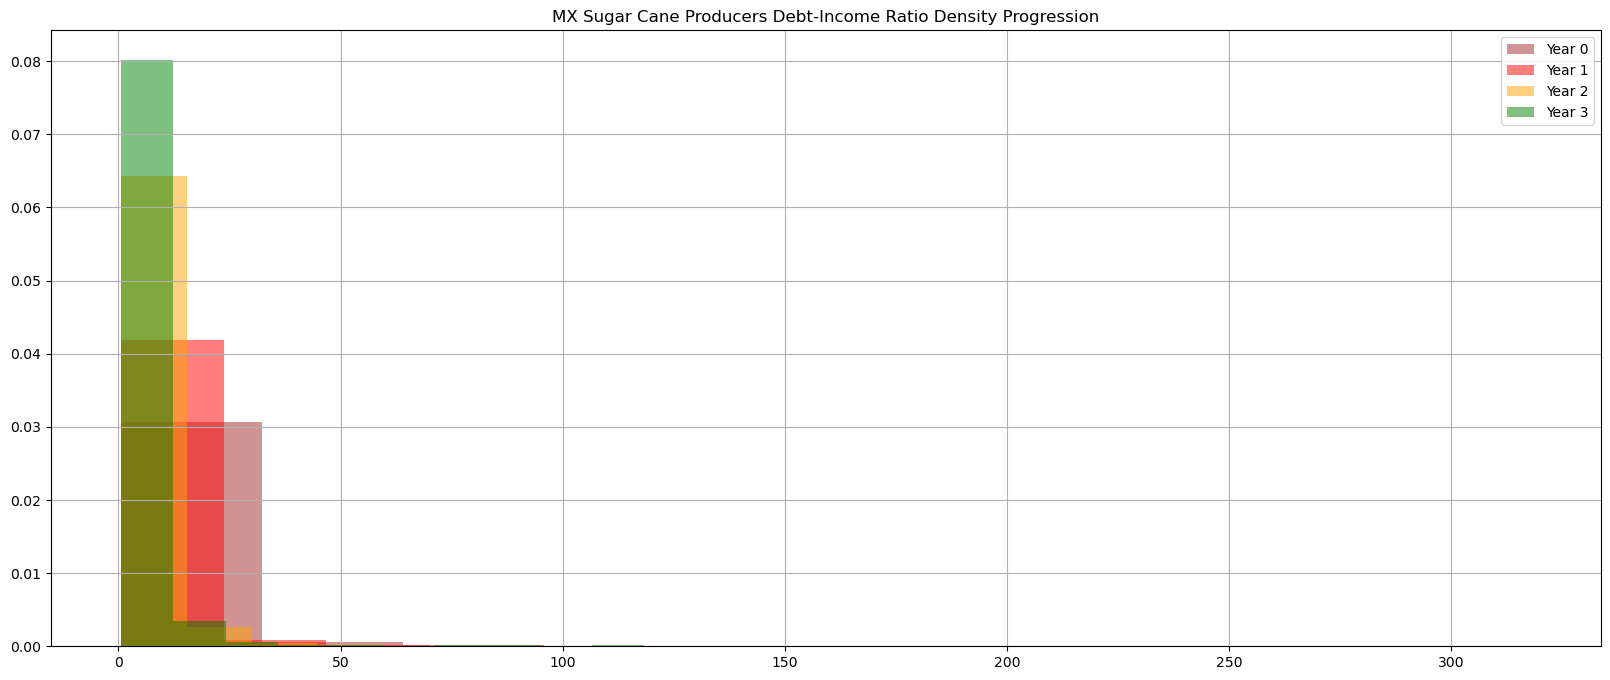

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot[('DEBT-INCOME RATIO',0)].hist(alpha=0.5,color='brown',ax=ax,density=True)
df_pivot[('DEBT-INCOME RATIO',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot[('DEBT-INCOME RATIO',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot[('DEBT-INCOME RATIO',3)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 0","Year 1","Year 2","Year 3"])
ax.set_title('MX Sugar Cane Producers Debt-Income Ratio Density Progression')
df_pivot[[('DEBT-INCOME RATIO',0),('DEBT-INCOME RATIO',1),('DEBT-INCOME RATIO',2),('DEBT-INCOME RATIO',3),('DEBT-INCOME RATIO',4)]].describe()

### Clasificación Financiera de Productores

Se presenta un esquema de **clasificación financiera** de los productores, en función de la **Pérdida Esperada**.

La Pérdida Esperada es una estimación del monto financiero que podría perderse en función del **Riesgo de Impago** de un productor.

El **Riesgo de Impago (%)** (también conocido como *Probability of Default*). Normalmente es función de las condiciones económicas del país, las características socio-económicas del solicitante y otros factores externos. Las herramientas utilizadas comprenden el "credit scoring", modelos probabilísticos de estimación basados en históricos (normalmente modelos de regresión logística o de machine learning). Estos enfoques sin embargo requieren disponer de una historia crediticia del solicitante. Para el caso específico en estudio, no se cuenta con esta información por lo que se propone un enfoque alternativo.

#### Cociente Deuda a Ingresos
El cociente *Deuda a Ingreso* (Income-Debt Ratio) es el porcentaje del Ingreso Mensual Bruto que se destina a cubrir obligaciones de Deuda, entre ellas *préstamos, tarifas, impuestos, primas de seguros, etc*. Este cociente (en conjunto con el "credit scoring") es la variable más relevante en la determinación de la *Probabilidad de Impago* y es más sencillo de obtener porque requiere de información crediticia básica del productor.

Debido a esto, formulamos un modelo de *Regresión Logística* de una variable, con la forma:

$$ DefaultProbability = \frac {e^{(\beta_0 + \beta_1 * IncomeDebtRatio)}}{1+e^{(\beta_0 + \beta_1 * IncomeDebtRatio)}}$$

Este modelo supone determinar los coeficientes $\beta_0$ y $\beta_1$ óptimos para la estimación correcta del riesgo. Normalmente esto se realiza de forma similar a una regresión con datos históricos. En este caso no se cuenta con esta información, por lo que se propone un enfoque alternativo por medio de una **estimación de dos puntos**, en la cual se resuelven dos ecuaciones con dos incógnitas.

Suponga que se tiene información de los productores en la que:
- Un cociente deuda-ingreso $R_0$ se asocia con una probabilidad de incumplimiento $P_0$
- Un cociente deuda-ingreso $R_1$ se asocia con una probabilidad de incumplimiento $P_1$

Se resuelven las ecuaciones para encontrar los parámetros de la regresión, con el siguiente resultado:
$$\beta_1 = \frac{1}{R_0-R_1} * [ln(\frac{P_0}{1-P_0}) - ln(\frac{P_1}{1-P_1})]$$
$$\beta_0 = ln(\frac{P_0}{1-P_0}) - \beta_1*R_0$$

Esto permite estimar el **Riesgo de Impago** dados dos puntos de referencia relacionados al **Cociente Deuda-Ingreso**

In [17]:
# Estimación de Dos Puntos (Debt_Income_Ratio, Probability_of_Default)
R_0 = 3    # Ratio Deuda - Ingreso No. 1
P_0 = 0.2  # Probabilidad de Impago asociada al Ratio Deuda-Ingreso No. 1

R_1 = 8    # Ratio Deuda - Ingreso No. 2
P_1 = 0.8  # Probabilidad de Impago asociada al Ratio Deuda-Ingreso No. 2

[Text(0.5, 1.0, 'Riesgo de Impago (%)')]

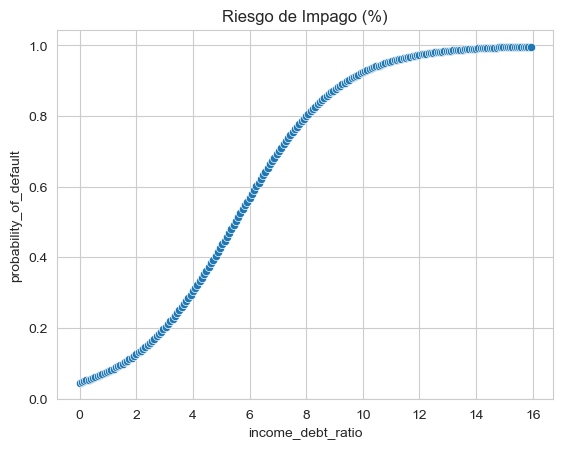

In [18]:
# Coeficientes de Regresión Logística
beta_1 = (1/(R_0-R_1))*(np.log(P_0/(1-P_0))-np.log(P_1/(1-P_1)))
beta_0 = np.log(P_0/(1-P_0))-beta_1*R_0

# Curva Probabilidades de Impago vs. Ratios Deuda-Ingreso
ratios = np.arange(0,R_1*2,R_1/100)
probabilities = 1/(1+np.exp(-(beta_0+beta_1*ratios)))
d = {"income_debt_ratio":ratios,"probability_of_default":probabilities}
prob_df = pd.DataFrame(d)
sns.set_style("whitegrid")
sns.scatterplot(x="income_debt_ratio",y="probability_of_default",data=prob_df).set(title='Riesgo de Impago (%)')

In [19]:
# Probabilitiy of Default as a function of Debt-Income Ratio
df1 = 1/(1+np.exp(-(beta_0+beta_1*df_pivot['DEBT-INCOME RATIO'])))
df1.columns = [['PROBABILITY OF DEFAULT'] * len(df1.columns), df1.columns]

df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398.626351   398.626351   

                           CORTE                CUOTA CONADESUCA             \
ZAFRA                    4    -1    0    1    2                0          1   
NUMERO CAÑERO                                                                 
5101009        1163.557998   0.0  0.0  1.0  2.0        17.453370  17.453370   
5101012         107.736852   0.0  1.0  2.0  3.0         1.616053   1.616053   
5101013         991.179035   0.0  0.0  1.0  2.0        14.867686  14.867686   
5101117         140.057907   0.0  0.0  1.0  2.0         2.100869   2.100869   
5101138

### Progresión de la Distribución del Riesgo de Impago

Se presenta la distribuición del Riesgo de Impago de los productores. Por medio de este análisis gráfico puede observarse el comportamiento del riesgo al avanzar los años, de acuerdo con el ratio Deuda-Ingreso proyectado para cada productor.

*Es deseable que la distribución reduzca su varianza y su media al transcurrir los años*.

PROBABILITY OF DEFAULT                                         \
ZAFRA                      0            1            2            3   
count            1469.000000  1469.000000  1469.000000  1469.000000   
mean                0.438938     0.407925     0.379776     0.324312   
std                 0.292387     0.280447     0.271165     0.258681   
min                 0.063697     0.063697     0.063697     0.062708   
25%                 0.202830     0.186241     0.178857     0.145102   
50%                 0.333500     0.305307     0.288940     0.218457   
75%                 0.617249     0.541641     0.482634     0.385909   
max                 1.000000     1.000000     1.000000     1.000000   

                    
ZAFRA            4  
count  1469.000000  
mean      0.219271  
std       0.211925  
min       0.060775  
25%       0.100719  
50%       0.140021  
75%       0.221021  
max       1.000000

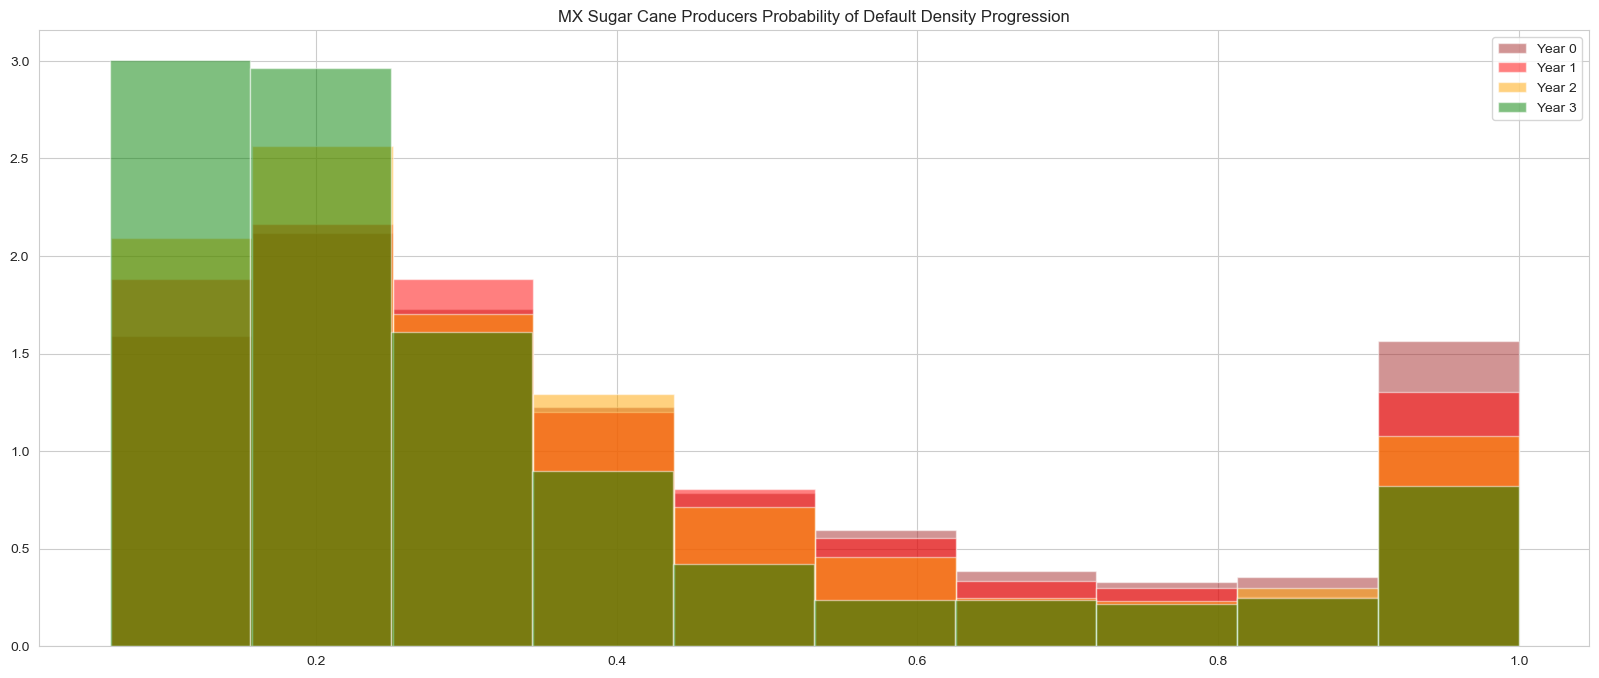

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot[('PROBABILITY OF DEFAULT',0)].hist(alpha=0.5,color='brown',ax=ax,density=True)
df_pivot[('PROBABILITY OF DEFAULT',1)].hist(alpha=0.5,color='red',ax=ax,density=True)
df_pivot[('PROBABILITY OF DEFAULT',2)].hist(alpha=0.5,color='orange',ax=ax,density=True)
df_pivot[('PROBABILITY OF DEFAULT',3)].hist(alpha=0.5,color='green',ax=ax,density=True)
ax.legend(["Year 0","Year 1","Year 2","Year 3"])
ax.set_title('MX Sugar Cane Producers Probability of Default Density Progression')
df_pivot[[('PROBABILITY OF DEFAULT',0),('PROBABILITY OF DEFAULT',1),('PROBABILITY OF DEFAULT',2),('PROBABILITY OF DEFAULT',3),('PROBABILITY OF DEFAULT',4)]].describe()

In [21]:
# Saldos de Deuda Incremental Total
df1_siembra = df_pivot[('AMORTIZACION APS')][df_pivot[('SIEMBRA',0)]==1] + df_pivot[('AMORTIZACION MANEJO')][df_pivot[('SIEMBRA',0)]==1]
df1_manejo = df_pivot[('AMORTIZACION MANEJO')][df_pivot[('SIEMBRA',0)]==0]
df1 = pd.concat([df1_siembra,df1_manejo],axis=0).sort_values(by=['NUMERO CAÑERO'])
df1.columns = [['AMORTIZACION TOTAL'] * len(df1.columns), df1.columns]

df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              AMORTIZACION TOTAL                                       \
ZAFRA                          0         1        2        3        4   
NUMERO CAÑERO                                                           
5101009                      0.0  111150.0  89775.0  89775.0  68400.0   
5101012                   2000.0    2000.0   2000.0   2000.0   2000.0   
5101013                      0.0   29900.0  24150.0  24150.0  18400.0   
5101117                      0.0    4225.0   3412.5   3412.5   2600.0   
5101138                      0.0   12025.0   9712.5   9712.5   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398

### Cálculo de Pérdida Esperada

In [22]:
### Pérdida Esperada
df1 = df_pivot['PROBABILITY OF DEFAULT']*df_pivot['AMORTIZACION TOTAL']
df1.columns = [['PERDIDA ESPERADA'] * len(df1.columns), df1.columns]
df_pivot = df_pivot.join([df1])

df_pivot = df_pivot.sort_index(axis=1)
df_pivot.head()

AMORTIZACION APS                                  \
ZAFRA                        0        1        2        3    4   
NUMERO CAÑERO                                                    
5101009                    0.0  42750.0  21375.0  21375.0  0.0   
5101012                    0.0   1250.0    625.0    625.0  0.0   
5101013                    0.0  11500.0   5750.0   5750.0  0.0   
5101117                    0.0   1625.0    812.5    812.5  0.0   
5101138                    0.0   4625.0   2312.5   2312.5  0.0   

              AMORTIZACION MANEJO                                      \
ZAFRA                           0        1        2        3        4   
NUMERO CAÑERO                                                           
5101009                       0.0  68400.0  68400.0  68400.0  68400.0   
5101012                    2000.0   2000.0   2000.0   2000.0   2000.0   
5101013                       0.0  18400.0  18400.0  18400.0  18400.0   
5101117                       0.0   2600.0   2600.0   2600.0   2600.0   
5101138                       0.0   7400.0   7400.0   7400.0   7400.0   

              AMORTIZACION TOTAL                                       \
ZAFRA                          0         1        2        3        4   
NUMERO CAÑERO                                                           
5101009                      0.0  111150.0  89775.0  89775.0  68400.0   
5101012                   2000.0    2000.0   2000.0   2000.0   2000.0   
5101013                      0.0   29900.0  24150.0  24150.0  18400.0   
5101117                      0.0    4225.0   3412.5   3412.5   2600.0   
5101138                      0.0   12025.0   9712.5   9712.5   7400.0   

              Area total                          BENEFICIO                \
ZAFRA                 -1      0      1      2             0             1   
NUMERO CAÑERO                                                               
5101009            27.00  27.00  27.00  27.00  75631.269876  75631.269876   
5101012             2.50   2.50   2.50   2.50   7002.895359   7002.895359   
5101013            23.00  23.00  23.00  23.00  64426.637302  64426.637302   
5101117             3.25   3.25   3.25   3.25   9103.763967   9103.763967   
5101138             9.25   9.25   9.25   9.25  25910.712828  25910.712828   

                                                                  CAT  \
ZAFRA                     2             3             4             0   
NUMERO CAÑERO                                                           
5101009        75631.269876  75631.269876  75631.269876  13574.882096   
5101012         7002.895359   7002.895359   7002.895359   1256.933527   
5101013        64426.637302  64426.637302  64426.637302  11563.788452   
5101117         9103.763967   9103.763967   9103.763967   1634.013586   
5101138        25910.712828  25910.712828  25910.712828   4650.654052   

                                                                       \
ZAFRA                     1             2             3             4   
NUMERO CAÑERO                                                           
5101009        13574.882096  13574.882096  13574.882096  13574.882096   
5101012         1256.933527   1256.933527   1256.933527   1256.933527   
5101013        11563.788452  11563.788452  11563.788452  11563.788452   
5101117         1634.013586   1634.013586   1634.013586   1634.013586   
5101138         4650.654052   4650.654052   4650.654052   4650.654052   

                CAÑA TOTAL                                         \
ZAFRA                    0            1            2            3   
NUMERO CAÑERO                                                       
5101009        1163.557998  1163.557998  1163.557998  1163.557998   
5101012         107.736852   107.736852   107.736852   107.736852   
5101013         991.179035   991.179035   991.179035   991.179035   
5101117         140.057907   140.057907   140.057907   140.057907   
5101138         398.626351   398.626351   398

PERDIDA ESPERADA                                               \
ZAFRA                0              1              2              3   
count      1469.000000    1469.000000    1469.000000    1469.000000   
mean       1696.733073    5035.313673    4098.396163    3560.287254   
std        6239.450814   12519.647064   10386.146896    9618.148059   
min           0.000000      40.438908      40.438908      39.366923   
25%           0.000000    1103.594307     981.936619     827.283642   
50%           0.000000    2000.285195    1655.951196    1355.958294   
75%        1454.660944    4025.491346    3121.303627    2521.765504   
max      126093.977862  198900.000000  160650.000000  160650.000000   

                      
ZAFRA              4  
count    1469.000000  
mean     2055.308906  
std      6343.414866  
min        37.301815  
25%       500.666494  
50%       763.541333  
75%      1231.109998  
max    122399.999981

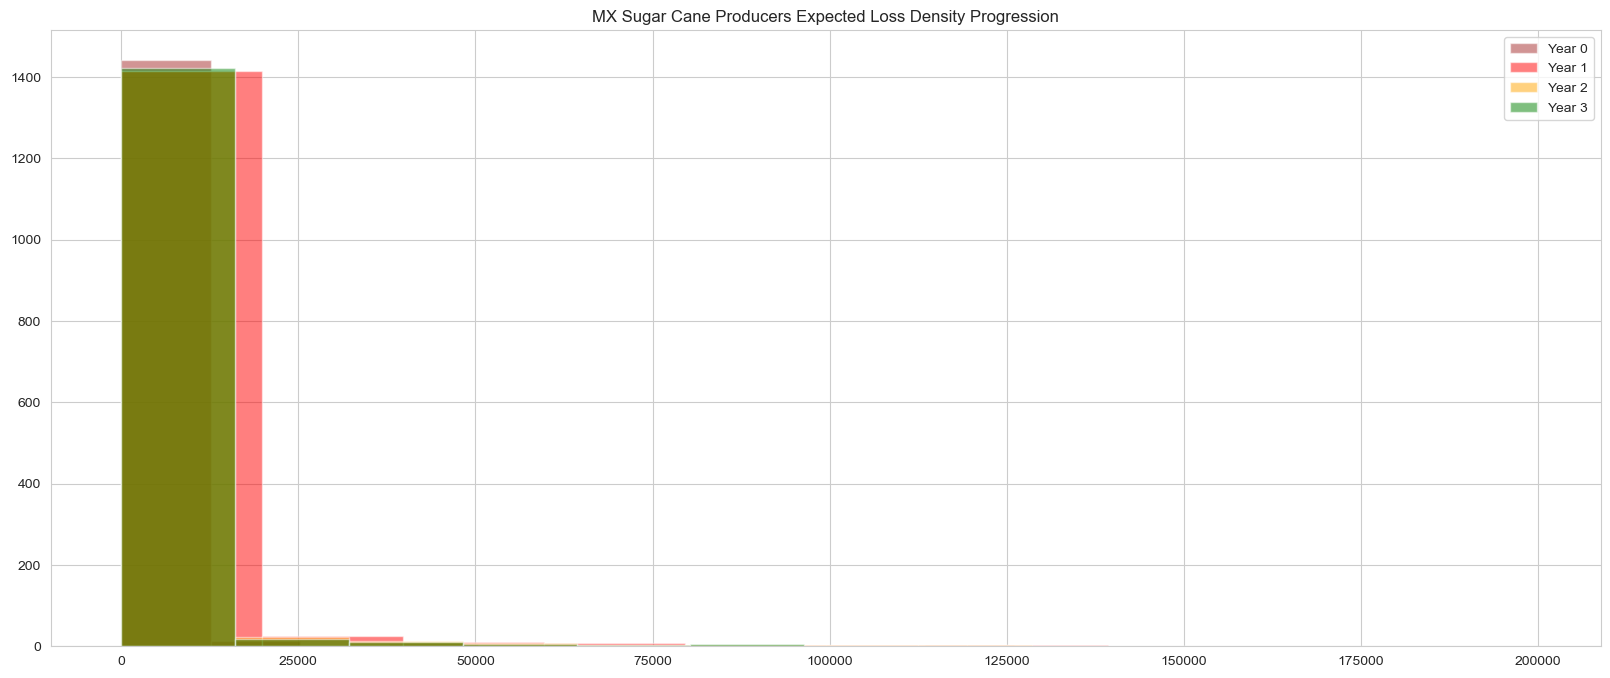

In [23]:
fig, ax = plt.subplots(figsize=(20, 8))
df_pivot[('PERDIDA ESPERADA',0)].hist(alpha=0.5,color='brown',ax=ax)
df_pivot[('PERDIDA ESPERADA',1)].hist(alpha=0.5,color='red',ax=ax)
df_pivot[('PERDIDA ESPERADA',2)].hist(alpha=0.5,color='orange',ax=ax)
df_pivot[('PERDIDA ESPERADA',3)].hist(alpha=0.5,color='green',ax=ax)
ax.legend(["Year 0","Year 1","Year 2","Year 3"])
ax.set_title('MX Sugar Cane Producers Expected Loss Density Progression')
df_pivot[[('PERDIDA ESPERADA',0),('PERDIDA ESPERADA',1),('PERDIDA ESPERADA',2),('PERDIDA ESPERADA',3),('PERDIDA ESPERADA',4)]].describe()

In [24]:
df_loss = pd.DataFrame(df_pivot[('PERDIDA ESPERADA')].sum(axis=1))
df_loss.columns = ['TOTAL EXPECTED LOSS']
df_loss.head()

,TOTAL EXPECTED LOSS
NUMERO CAÑERO,
5101009,316400.562477
5101012,2600.254043
5101013,15143.992780
5101117,6146.054200
5101138,9436.536122


### Clasificación de Productores

La clasificación de los productores se realizar asignando una categoría C1, C2, C3, C4,... dependiendo de la Pérdida Esperada que se estimó para cada uno.


#### Clasificación Ordinal

Esta es una clasificación respecto al orden de la pérdida, y es función de la distribución de valores de pérdida.

Por ejemplo, se muestra abajo:
- Categoría 1 (C1): 20% de los productores con pérdida esperada más baja.
- Categoría 2 (C2): 30% de los productores con la siguiente pérdida esperada más baja.
- Categoría 3 (C3): 35% de los productores con la siguiente pérdida esperada más baja.
- Categoría 4 (C4): 15% de los productores con la pérdida esperada más alta.

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101009              316400.562477     D
5101012                2600.254043     A
5101013               15143.992780     C
5101117                6146.054200     B
5101138                9436.536122     C


<Axes: xlabel='CLASS', ylabel='Count'>

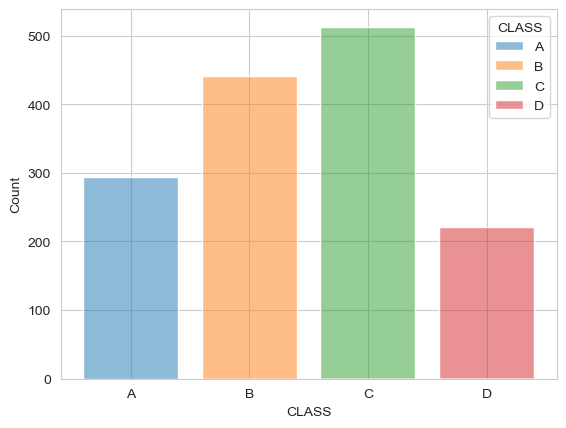

In [25]:
# Clasificación de Productores
df_loss['CLASS'] = pd.qcut(df_loss[('TOTAL EXPECTED LOSS')], q=[0,.2,.5,.85,1], labels=['A','B','C','D'])
print(df_loss.head())
sns.histplot(data=df_loss, x='CLASS',hue='CLASS',shrink=.8)

#### Clasificación por Rangos

Esta es una clasificación respecto a rangos establecidos de pérdida.

Por ejemplo, se muestra abajo:
- Categoría 1 (C1): Los productores con pérdida esperada entre 0 y 6000.
- Categoría 2 (C2): Los productores con pérdida esperada entre 6000 y 10000.
- Categoría 3 (C3): Los productores con pérdida esperada entre 10000 y 30000.
- Categoría 4 (C4): Los productores con pérdida esperada entre 30000 y 150000.

               TOTAL EXPECTED LOSS CLASS
NUMERO CAÑERO                           
5101009              316400.562477   NaN
5101012                2600.254043     A
5101013               15143.992780     C
5101117                6146.054200     B
5101138                9436.536122     B


<Axes: xlabel='CLASS', ylabel='Count'>

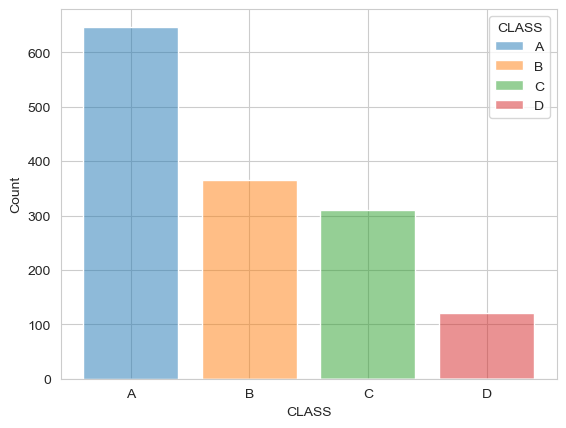

In [26]:
df_loss['CLASS'] = pd.cut(x=df_loss['TOTAL EXPECTED LOSS'], bins=[0, 6000, 10000, 30000, 150000],
                    labels=['A','B','C','D'])
print(df_loss.head())
sns.histplot(data=df_loss, x='CLASS',hue='CLASS',shrink=.8)